# Compositing

## Goal

The goal of this experiment is to find the optimal number of composites per year for each compositing method. We choose from a selection of compositing methods offered by the Earth Engine API, called [ImageCollection Reductions](https://developers.google.com/earth-engine/guides/reducers_image_collection).

## Experiment

The experiment is conducted as follows:

- A time window of 1 year is used per study area, covering each year of recording.
- We select the ideal number of composites per compositing method from 1, 2, 4, 6, and 12 number of composites per year.
- Only the optimal bands determined in the previous experiment are used.
- Random Forest from scikit-learn with default parameters is chosen as the classification model.
- F1 Score with stratified 5-fold cross validation will be used for determining the optimal number of composites per compositing method.

We start by listing all available reducers:

In [1]:
# List the available reducers
from logging import INFO
from sys import stdout

from loguru import logger

from slc.data import list_reducers

logger.configure(handlers=[{"sink": stdout, "format": "{message}", "level": INFO}])

reducers = list_reducers()

logger.info(f"ImageCollection Reductions: {reducers}")

ImageCollection Reductions: ['And', 'Or', 'allNonZero', 'anyNonZero', 'bitwiseAnd', 'bitwiseOr', 'circularMean', 'circularStddev', 'circularVariance', 'count', 'countDistinct', 'countDistinctNonNull', 'countRuns', 'first', 'firstNonNull', 'kendallsCorrelation', 'kurtosis', 'last', 'lastNonNull', 'max', 'mean', 'median', 'min', 'minMax', 'mode', 'product', 'sampleStdDev', 'sampleVariance', 'skew', 'stdDev', 'sum', 'variance']


The reducers can be divided into groups based on their functionality to select the most appropriate reducers for our problem. We group the reducers as follows:

| Reducer Group                      | Reducers                                                      |
| ---------------------------------- | ------------------------------------------------------------- |
| Non-zero based                     | `And` `Or` `allNonZero` `anyNonZero`                          |
| Bitwise                            | `bitwiseAnd` `bitwiseOr`                                      |
| Descriptive statistics (radians)   | `circularMean` `circularStddev` `circularVariance`            |
| Non-null based                     | `count`                                                       |
| Value counts                       | `countDistinct` `countDistinctNonNull` `countRuns`            |
| Single image                       | `first` `firstNonNull` `last` `lastNonNull`                   |
| Correlation                        | `kendallsCorrelation`                                         |
| Descriptive statistics             | `kurtosis` `max` `mean` `median` `min` `minMax` `mode` `skew` |
| Arithmetic result                  | `product` `sum`                                               |
| Descriptive statistics (deviation) | `sampleStdDev` `sampleVariance` `stdDev` `variance`           |

We will continue with only select descriptive statistics and the `sampleStdDev` to keep the number of reducers at a minimum while covering relevant reducers for time series composition. Following reducers are selected:

In [2]:
reducers = [
    "max",
    "mean",
    "median",
    "min",
    "sampleStdDev",
    "skew",
]

Following Sentinel 2 Level-2A bands and indices were determined in the previous experiment and are used in this experiment:

In [3]:
# List the bands determined by the previous experiment
from slc.models import bands_from_importance

sentinel_bands, indices = bands_from_importance(
    "../reports/band_importance.csv", top_n=10
)

logger.info(f"Level-2A bands: {sentinel_bands}")
logger.info(f"Indices: {indices}")

Level-2A bands: ['B11']
Indices: ['BRBA', 'GDVI', 'IKAW', 'MBWI', 'MIRBI', 'MLSWI26', 'NBRplus', 'NMDI', 'SWI']


We perform a grid search on all combinations of compositing methods (see above) and number of composites (1, 2, 4, 6, 12) by creating datasets for each iteration in the search using the Earth Engine API. The resulting rasters are used to train a Random Forest classification model with 5-fold cross validation each. The F1 Scores are used to determine the optimal number of composites for each compositing method:

In [4]:
# Perform a grid exploration over all reducers and number of composites
from datetime import datetime
from itertools import product
from pathlib import Path
from time import sleep
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
from pqdm.threads import pqdm
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate
from tqdm.notebook import tqdm

from slc.data import sentinel_composite
from slc.features import interpolate_data, load_dataset, to_float32

tz = ZoneInfo("CET")

model = RandomForestClassifier(n_jobs=-1, random_state=42)
search_space = {
    "num_composites": [12, 6, 4, 2, 1],  # Reverse to start with slowest
    "temporal_reducers": [[reducer] for reducer in reducers],
    "indices": [indices],
    "sentinel_bands": [sentinel_bands],
}
scoring = {"F1 Score": make_scorer(f1_score)}
target_folder = Path("../data/processed/target/")


def _create_composite(args: tuple[Path, Path]) -> None:
    data_folder, target_path, search_point = args

    data_path = data_folder / target_path.name
    year = int(target_path.stem.split("_")[-1])

    # Create the composite (retrying if it fails)
    batch_size = None
    init_bs = 512
    while not data_path.exists():
        try:
            sentinel_composite(
                target_path_from=target_path,
                data_path_to=data_path,
                time_window=(
                    datetime(year, 1, 1, tzinfo=tz),
                    datetime(year + 1, 1, 1, tzinfo=tz),
                ),
                batch_size=batch_size,
                **search_point,
            )
        except KeyboardInterrupt as exc:  # noqa: PERF203
            raise KeyboardInterrupt from exc
        except Exception:  # noqa: BLE001
            if batch_size is not None:
                if batch_size < init_bs / 2:
                    sleep_time = 100 * 256 / batch_size
                    logger.debug(f"Sleeping for {sleep_time} seconds")
                    sleep(sleep_time)

                batch_size = batch_size // 2
            else:
                batch_size = init_bs

            logger.debug(f"Retrying with batch_size={batch_size}")


def _create_dataset(
    target_folder: Path, search_point: dict
) -> tuple[pd.DataFrame, pd.Series]:
    # Create data_path and ensure directory exists
    reducer = search_point["temporal_reducers"][0]
    composites = search_point["num_composites"]
    data_folder = Path(f"../data/processed/compositing/data_{reducer}_{composites}/")
    data_folder.mkdir(parents=True, exist_ok=True)

    # Create the 2A composite if it does not exist
    data_folder.mkdir(parents=True, exist_ok=True)
    all_args = [
        (data_folder, target_path, search_point)
        for target_path in target_folder.glob("*.tif")
    ]
    pqdm(all_args, _create_composite, n_jobs=10)

    # Fill missing values by linear (circular) interpolation
    data, target = load_dataset(data_folder, target_folder)
    interpolated_data = interpolate_data(data)
    interpolated_data = to_float32(interpolated_data)

    return interpolated_data, target


def _check_row_exists(search_point: dict) -> bool:
    try:
        history = pd.read_csv("../reports/compositing.csv")
        for _, row in history.iterrows():
            if list(row[:2]) == [
                search_point["temporal_reducers"][0],
                search_point["num_composites"],
            ]:
                return True
    except FileNotFoundError:
        return False
    else:
        return False


def _callback(scores: dict, scoring: dict, search_point: dict) -> None:
    # Read the compositing.csv
    compositing = "../reports/compositing.csv"
    try:
        history = pd.read_csv(compositing)
    except FileNotFoundError:
        columns = ["Reducer", "Composites", *list(scoring.keys())]
        history = pd.DataFrame(columns=columns)

    # Store the scores in the dataframe
    first_columns = [
        search_point["temporal_reducers"][0],
        search_point["num_composites"],
    ]
    last_columns = [scores[f"test_{key}"].mean() for key in scoring]
    idx = len(history)
    for i, row in history.iterrows():
        if list(row[:2]) == first_columns:
            idx = i
    history.loc[idx] = first_columns + last_columns

    # Save to CSV
    history.to_csv(compositing, index=False)


def _grid_exploration(
    model: ClassifierMixin,
    search_space: dict,
    scoring: dict,
    target_folder: Path,
) -> None:
    params = search_space.keys()
    for values in tqdm(list(product(*search_space.values())), desc="Grid Search"):
        search_point = dict(zip(params, values, strict=False))

        # Skip if the row already exists
        if _check_row_exists(search_point):
            continue

        data, target = _create_dataset(target_folder, search_point)

        n_splits = 5
        if len(data) < n_splits:
            scores = {f"test_{key}": np.full(1, np.nan) for key in scoring}
        else:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            scores = cross_validate(
                model, data, target, cv=cv, scoring=scoring, n_jobs=-1
            )
        _callback(scores, scoring, search_point)


_grid_exploration(model, search_space, scoring, target_folder)

Grid Search:   0%|          | 0/30 [00:00<?, ?it/s]

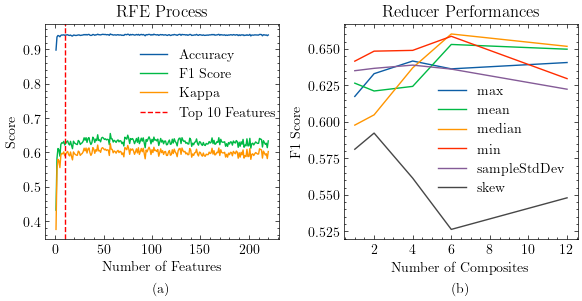

In [5]:
# Draw the RMSEs for each reducer across the number of composites per year
from pathlib import Path

import matplotlib.pyplot as plt
import scienceplots  # noqa: F401
from matplotlib import ticker

from slc.visualize import label_subplots, save_fig

plt.style.use("science")

score_df = pd.read_csv("../reports/band_importance.csv", index_col=0)

# Plot RFE scores
fig, axs = plt.subplots(
    ncols=2,
    figsize=(5.81, 3),
    constrained_layout=True,
)
ax = axs[0]
score_df["Index"] = range(1, score_df.shape[0] + 1)
score_df.plot(x="Index", y="Accuracy", label="Accuracy", ax=ax)
score_df.plot(x="Index", y="F1 Score", label="F1 Score", ax=ax)
score_df.plot(x="Index", y="Kappa", label="Kappa", ax=ax)
ax.axvline(10, color="red", linestyle="--", label="Top 10 Features")

# Format the plot
ax.set_title("RFE Process")
ax.set_xlabel("Number of Features")
ax.set_ylabel("Score")
ax.legend(loc="lower left", bbox_to_anchor=(0.35, 0.5))

history = pd.read_csv("../reports/compositing.csv")

ax = axs[1]
for name, group in history.groupby("Reducer"):
    group.plot(x="Composites", y="F1 Score", ax=ax, label=name)

# Format
ax.legend(loc="lower left", bbox_to_anchor=(0.35, 0.15))
ax.set_title("Reducer Performances")
ax.set_xlabel("Number of Composites")
ax.set_ylabel("F1 Score")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

label_subplots(axs, y_offset=0.2)

save_fig(fig, "../reports/figures/compositing/Importance And Compositing.pdf")

# Result

The optimal number of composites for each compositing method differs significantly. In above figure, the F1 scores for each compositing method are shown. For example the optimal number of composites per year for skew is low at 2, while compositing methods like max and median tend to perform better with a higher number of composites.

The max reducer is, alongside the skew reducer, the only one that improves beyond 6 composites. You can access [this GEE link](https://code.earthengine.google.com/39c0fc796f043a66102e9c80cbaa8d32) to get a feeling for the influence of unmasked clouds and snow on the indices when using the max reducer. The optimal number of composites for each compositing method is as follows:

In [6]:
# Find the best number of composites for each reducer
best_combinations = history.loc[history.groupby("Reducer")["F1 Score"].idxmax()]

best_composites = pd.DataFrame(
    data=best_combinations["Composites"].values,
    index=list(best_combinations["Reducer"]),
    columns=["Best Number of Composites"],
)

best_composites

,Best Number of Composites
max,4
mean,6
median,6
min,6
sampleStdDev,4
skew,2


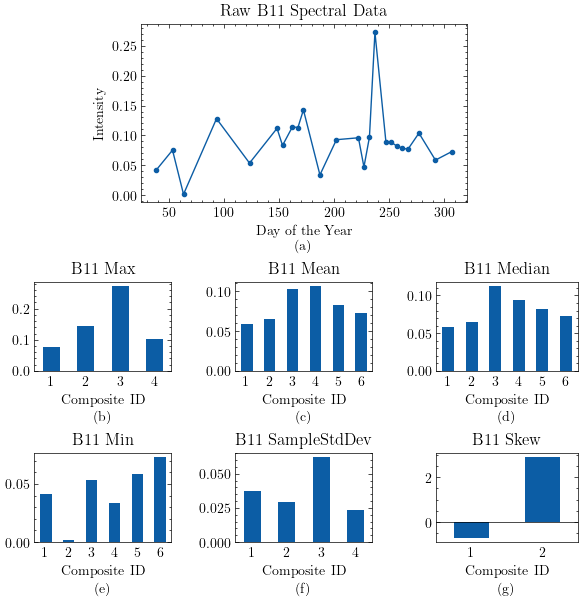

In [7]:
grid = [
    [".", "a", "a", "a", "a", "."],
    [".", "a", "a", "a", "a", "."],
    [".", "a", "a", "a", "a", "."],
    [".", "a", "a", "a", "a", "."],
    ["b", "b", "c", "c", "d", "d"],
    ["b", "b", "c", "c", "d", "d"],
    ["e", "e", "f", "f", "g", "g"],
    ["e", "e", "f", "f", "g", "g"],
]


fig, axs = plt.subplot_mosaic(
    grid,
    constrained_layout=True,
    figsize=(5.81, 6),
)
axs = np.asarray(list(axs.values()))


b11 = pd.DataFrame(
    {
        "B11": {
            38: 0.0414999984204769,
            53: 0.0753000006079673,
            63: 0.0013999999500811,
            93: 0.1280000060796737,
            123: 0.0535999983549118,
            148: 0.1118000000715255,
            153: 0.0832000002264976,
            162: 0.1142999976873397,
            167: 0.1132000014185905,
            172: 0.1427000015974044,
            187: 0.0337999984622001,
            202: 0.092799998819828,
            222: 0.096000000834465,
            227: 0.0471000000834465,
            232: 0.0970000028610229,
            237: 0.2727000117301941,
            247: 0.088699996471405,
            252: 0.0882999971508979,
            257: 0.0820000022649765,
            262: 0.0785999968647956,
            267: 0.0768000036478042,
            277: 0.1037999987602233,
            292: 0.0586000010371208,
            307: 0.0729999989271164,
        }
    },
).rename_axis("Day of the Year")

b11.plot(
    title="Raw B11 Spectral Data",
    ylabel="Intensity",
    marker=".",
    legend=False,
    ax=axs[0],
)

results = pd.read_csv("../reports/compositing.csv")
optima = results.loc[results.groupby("Reducer")["F1 Score"].idxmax()].reset_index()

for i, (reducer, num_composites) in optima[["Reducer", "Composites"]].iterrows():
    composite_length_days = 365 / num_composites
    means = {}
    for j in range(num_composites):
        indices = (b11.index - 1) // composite_length_days == j
        composite = b11.loc[indices]
        means[j + 1] = getattr(
            composite, reducer if reducer != "sampleStdDev" else "std"
        )()

    means = pd.DataFrame(means).T
    means.plot(
        title="B11 " + reducer[0].upper() + reducer[1:],
        kind="bar",
        legend=False,
        xlabel="Composite ID",
        ax=axs[i + 1],
        rot=0,
    )
    axs[i + 1].tick_params(axis="x", which="both", length=0)
    axs[i + 1].axhline(0, color="black", linewidth=0.5)

label_subplots(axs, y_offset=[0.21] + [0.45] * 6)

save_fig(fig, "../reports/figures/compositing/Compositing Example.pdf")

Above figure shows the differences between the different reducers. We use this combination of compositing method and number of composites to create the final dataset used for hyperparameter tuning in the next experiment. Any empty composite pixel wille be filled with cyclic linear interpolation between the nearest non-empty pixels in time:

In [8]:
data_path = Path("../data/processed/compositing/data.csv")
target_path = Path("../data/processed/compositing/target.csv")

if (not data_path.exists()) or (not target_path.exists()):
    total_data = []
    for reducer, row in tqdm(list(best_composites.iterrows())):
        num_composites = row["Best Number of Composites"]
        curr_data, total_target = load_dataset(
            f"../data/processed/compositing/data_{reducer}_{num_composites}/",
            target_folder,
        )
        total_data.append(interpolate_data(curr_data))

    total_data = pd.concat(total_data, axis=1)

    total_data.to_csv(data_path, index=False)
    total_target.to_csv(target_path, index=False)
else:
    total_data = pd.read_csv(data_path)
    total_target = pd.read_csv(target_path)["0"]

logger.info(f"Number of Features: {total_data.shape[1]}")

Number of Features: 280
